#### Инициализация

In [1]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

'''Частота излучения и сечение поглощения'''
frequency = 709078373.01 * 10 ** 6 # [Hz]
c = 299792458 # [m/s]
wavelength = (c/frequency) * 10 ** 2 # [cm]
crosssection = (3 * wavelength ** 2 ) / (2 * np.pi) # [cm^2]

rows, columns = (768, 1024)
'''Калибровка'''# [cm/px]
Kx_abs = 0.0006272973203202318

#### Обработка поглощения

In [2]:
file_abs = "image_4"
directory = r"../2025-06-xx_densityScan-vrDetuning/b=35/d=6.38V//"
#directory = r"../..//" #desktop

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + file_abs + ".tif") #initially a grayscale image

shots = []
try:
    while True:
        frame = np.array(img)
        shots.append(frame)
        img.seek(img.tell() + 1) #go to next frame
except EOFError: #end of frames case
    pass

I_atoms = shots[0] #I
I_lbeam = shots[1] #I0
bias = shots[2]

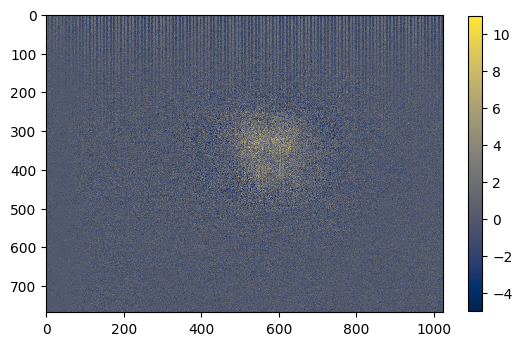

In [3]:
'''Приведение к uint16 и замена нулей, чтобы не возникало ошибок при делении матриц'''
num = (I_atoms - bias).astype(np.uint16) + 1
denom = (I_lbeam - bias).astype(np.uint16) + 1

'''Определение пропускания T(x,y)'''
T = (num/denom).astype(np.float32)

'''Визуализация'''
D = I_lbeam.astype(np.int16)-I_atoms.astype(np.int16)
plt.imshow(D, cmap="cividis", interpolation="none")
plt.colorbar(shrink=.8)

#### Поиск центра облака

In [5]:
'''Фильтрация физичных T<=1'''
F = np.copy(T)
for i in range(rows):
    for j in range(columns):
        if T[i, j] > 1:
            F[i, j] = 1

ker = 25
'''Сглаживание шумов'''
M = cv2.medianBlur(F, 5)
G = cv2.GaussianBlur(M, (ker, ker), 0)

In [11]:
%matplotlib qt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal

fig, main_ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(main_ax)
top_ax = divider.append_axes("top", 1.05, pad=0.1, sharex=main_ax)
right_ax = divider.append_axes("right", 1.05, pad=0.1, sharey=main_ax)

# make some labels invisible
top_ax.xaxis.set_tick_params(labelbottom=False)
right_ax.yaxis.set_tick_params(labelleft=False)

x, y = np.mgrid[0:columns, 0:rows]
z = M
z_max = z.max()

main_ax.imshow(z, origin='upper')
main_ax.autoscale(enable=False)
right_ax.autoscale(enable=False)
top_ax.autoscale(enable=False)
right_ax.set_xlim(right=z_max)
top_ax.set_ylim(top=z_max)
v_line = main_ax.axvline(np.nan, color='grey')
h_line = main_ax.axhline(np.nan, color='grey')
v_prof, = right_ax.plot(np.zeros(x.shape[1]),np.arange(x.shape[1]), '-', c="grey")
h_prof, = top_ax.plot(np.arange(x.shape[0]),np.zeros(x.shape[0]), 'g-', c="grey")

def on_move(event):
    if event.inaxes is main_ax:
        cur_x = event.xdata
        cur_y = event.ydata

        v_line.set_xdata([cur_x,cur_x])
        h_line.set_ydata([cur_y,cur_y])
        v_prof.set_xdata(z[:,int(cur_x)])
        h_prof.set_ydata(z[int(cur_y),:])

        fig.canvas.draw_idle()

clicked_points = []
click_marker = main_ax.plot([], [], 'r.', markersize=10)[0]
def on_click(event):
    if event.inaxes is main_ax and event.button == 1:  # Left-click
        cur_x = event.xdata
        cur_y = event.ydata
        cur_z = z[int(cur_y), int(cur_x)]  # Get Z-value at clicked pixel
        
        # Save the point
        clicked_points.append((cur_x, cur_y, cur_z))
        print(f"Saved: T={cur_z:.2f}; ij={cur_y:.2f}, {cur_x:.2f}")
        
        # Update marker
        click_marker.set_data([cur_x], [cur_y])
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_1444\3376451010.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  h_prof, = top_ax.plot(np.arange(x.shape[0]),np.zeros(x.shape[0]), 'g-', c="grey")


Saved: T=0.86; ij=343.94, 587.52
Saved: T=0.86; ij=356.35, 590.63
Saved: T=0.92; ij=370.31, 627.86
Saved: T=0.88; ij=387.38, 651.14
Saved: T=0.94; ij=399.79, 632.52
Saved: T=0.94; ij=409.10, 626.31
Saved: T=0.92; ij=440.13, 658.89
Saved: T=0.91; ij=395.14, 568.91
Saved: T=0.93; ij=359.45, 584.42
Saved: T=0.91; ij=359.45, 618.55
Saved: T=0.87; ij=339.28, 590.63
Saved: T=0.93; ij=359.45, 584.42


#### Обработка центральной горизонтали

fwhm: 163.463 ± 3.654 px
peak absorption: 11.907% ± 0.231%
________________________________
χ²-reduced: 0.000
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)
Fit explains 74.907% of data (R² param)


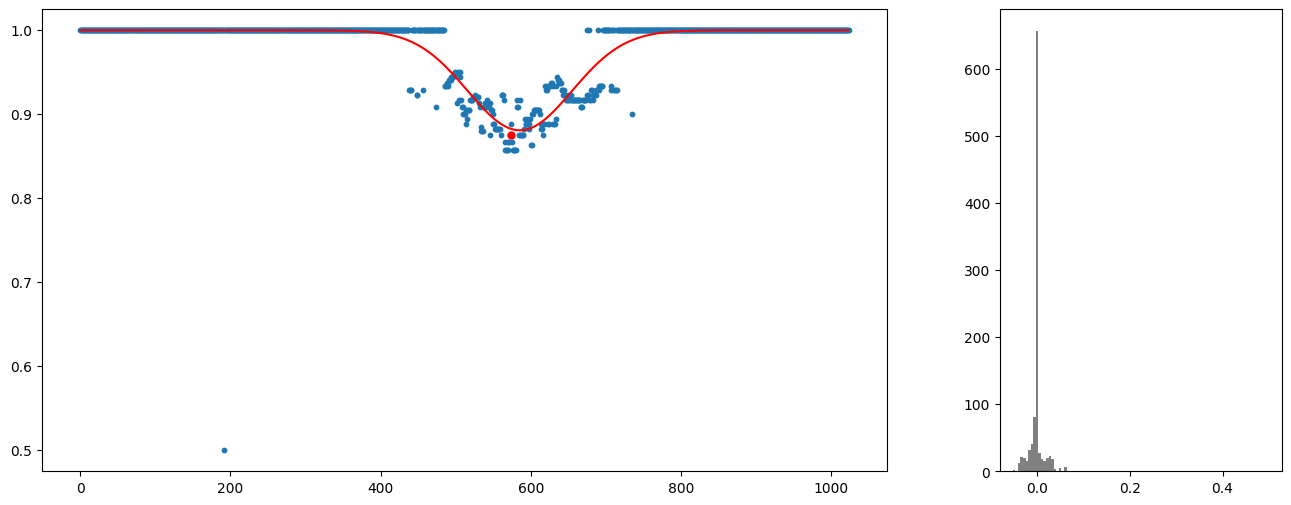

In [168]:
'''Профиль по оси j (для величины w_x)'''
data = 1-M[ic_abs, :]
arg = np.arange(0, columns, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
fwhm_abs = out.params["fwhm"].value
w_abs = out.params["sigma"].value

print("fwhm: %.3f ± %.3f px" % (fwhm_abs, out.params["fwhm"].stderr)) #stderr соответствует p = 0.68 (1-сигма)
#print("w_x: %.3f ± %.3f px" % (w_abs, out.params["sigma"].stderr))
print("peak absorption: %.3f%% ± %.3f%%" % (out.params["height"].value*100, out.params["height"].stderr*100))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(jc_abs, 1-data[jc_abs], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

#### Расчёт концентрации

In [169]:
'''Расчет пиковой концентрации.'''
n0 = -np.log(T[ic_abs, jc_abs])/(np.sqrt(2*np.pi)*w_abs*Kx_abs*crosssection)
print("n0: %.2e cm^-3" % n0)

n0: 2.40e+09 cm^-3


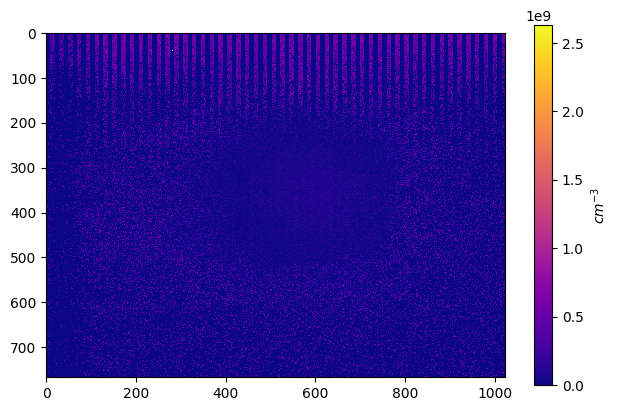

In [132]:
'''Профиль концентрации атомов n(x, y)'''
n = -np.log(T)/(np.sqrt(2*np.pi)*w_abs*Kx_abs*crosssection).astype(np.float32)

'''Фильтрация физичных плотностей'''
for i in range(rows): #rows
    for j in range(columns): #columns
        if n[i, j] < 0.:
            n[i, j] = 0.
        elif n[i, j] > n0:
            n[i, j] = 0.

'''Визуализация'''
plt.imshow(n, cmap="plasma", interpolation="none")
plt.colorbar(shrink=.8, label="$cm^{-3}$")
plt.tight_layout()
plt.savefig("clouds/n0=%.2e.png"%n0)